In [14]:
%pip install pandas 
%pip install tensorflow
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 160.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 105.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 1000
n_features = 286

# Features with some correlation to the target
X = np.random.randn(n_samples, n_features)
# Introduce NaNs in some features (random 10% missing values)
nan_mask = np.random.rand(n_samples, n_features) < 0.1
X[nan_mask] = np.nan

# Generate target variable with correlation to the first few features
# Adding noise for realistic correlation
y = 5 * X[:, 0] + 2 * X[:, 1] - 3 * X[:, 2] + np.random.randn(n_samples) * 0.5

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert X_train and X_test to Pandas DataFrames to simulate your setup
train_x = pd.DataFrame(X_train)
test_x = pd.DataFrame(X_test)

train_y = y_train
test_y = y_test

# Verify the number of NaN values
print("Number of NaNs in training data:", np.isnan(train_x).sum().sum())

Number of NaNs in training data: 22807


In [16]:
# Custom Imputation Layer with NaN Check
class ImputationLayer(tf.keras.layers.Layer):
    def __init__(self, strategy="mean", **kwargs):
        super(ImputationLayer, self).__init__(**kwargs)
        self.strategy = strategy

    def build(self, input_shape):
        if self.strategy == "mean":
            self.feature_means = self.add_weight(
                shape=(input_shape[1],),
                initializer="zeros",
                trainable=False
            )
        super(ImputationLayer, self).build(input_shape)

    def call(self, inputs):
        if self.strategy == "mean":
            # Compute the mean of each feature ignoring NaNs
            is_not_nan = tf.math.logical_not(tf.math.is_nan(inputs))
            feature_sums = tf.reduce_sum(tf.where(is_not_nan, inputs, 0.0), axis=0)
            feature_counts = tf.reduce_sum(tf.cast(is_not_nan, tf.float32), axis=0)
            feature_means = feature_sums / tf.maximum(feature_counts, 1.0)  # Avoid divide by zero
            self.feature_means.assign(tf.squeeze(feature_means))

            # Replace NaNs with the feature mean
            imputed_inputs = tf.where(tf.math.is_nan(inputs), tf.reshape(self.feature_means, (1, -1, 1)), inputs)
        else:
            raise ValueError(f"Strategy '{self.strategy}' not supported.")

        # Check if any NaNs remain and replace them with zero
        imputed_inputs = tf.where(tf.math.is_nan(imputed_inputs), 0.0, imputed_inputs)

        return imputed_inputs

    def compute_output_shape(self, input_shape):
        return input_shape

# Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assuming train_x is already defined and preprocessed
# Reshape train_x to have shape (num_samples, 286, 1)
X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)

# Define the custom Tweedie loss function with clipping
def custom_tweedie_loss(y_true, y_pred):
    p = 1.5  # Tweedie power parameter

    # Clip predictions to avoid invalid operations (like log of negative values)
    epsilon = tf.keras.backend.epsilon()  # Small value to prevent division by zero
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.clip_by_value(tf.cast(y_pred, dtype=tf.float32), epsilon, None)  # Ensure predictions are positive

    loss = tf.reduce_mean(
        tf.math.pow(y_true, 2 - p) / ((1 - p) * (2 - p)) -
        y_true * tf.math.pow(y_pred, 1 - p) / (1 - p) +
        tf.math.pow(y_pred, 2 - p) / (2 - p)
    )
    return loss

# Define the model
model = Sequential([
    ImputationLayer(strategy="mean", input_shape=(286, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# # Compile the model with a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_tweedie_loss)

# # Train the model
# history = model.fit(X_train, train_y, epochs=5, batch_size=32, validation_split=0.2)

/tmp/ipykernel_454/1504077826.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(ImputationLayer, self).__init__(**kwargs)
2024-09-20 00:28:05.419542: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
# %pip install ml-dtypes==0.2.0
# %pip install -U jax jaxlib

In [18]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

# Custom callback to track gradients and learning curves
class GradientLogger(Callback):
    def __init__(self, model, validation_data, batch_size=32):
        super(GradientLogger, self).__init__()
        self.model = model
        self.validation_data = validation_data
        self.batch_size = batch_size
        self.epoch_gradients = []  # Store gradients for each epoch
        self.epoch_losses = []  # Store losses for each epoch
        self.epoch_val_losses = []  # Store validation losses

    def on_epoch_end(self, epoch, logs=None):
        # Compute gradients
        X_val, y_val = self.validation_data
        with tf.GradientTape() as tape:
            y_pred = self.model(X_train, training=True)
            loss_value = self.model.loss(y_train, y_pred)

        gradients = tape.gradient(loss_value, self.model.trainable_variables)
        grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])
        
        # Log the gradients and losses
        self.epoch_gradients.append(grad_norm)
        self.epoch_losses.append(logs["loss"])
        self.epoch_val_losses.append(logs["val_loss"])

    def plot_learning_curves(self):
        # Plot the loss curves
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_losses, label="Training Loss")
        plt.plot(self.epoch_val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()

        # Plot the gradient norms
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_gradients, label="Gradient Norm")
        plt.xlabel("Epoch")
        plt.ylabel("Average Gradient Norm")
        plt.title("Gradient Norms Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Assuming the dataset is already loaded and preprocessed (train_x, train_y, etc.)
X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

# Initialize the custom callback
gradient_logger = GradientLogger(model, validation_data=(X_val, test_y))

# Train the model with the custom callback
history = model.fit(X_train, train_y, 
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[gradient_logger])

# After training, plot the learning curves and gradient norms
gradient_logger.plot_learning_curves()

AttributeError: property 'model' of 'GradientLogger' object has no setter

In [22]:
# # Custom callback to track gradients and learning curves
# import tensorflow as tf
# from tensorflow.keras.callbacks import Callback
# import matplotlib.pyplot as plt
# import numpy as np

# class GradientLogger(Callback):
#     def __init__(self, validation_data, batch_size=32):
#         super(GradientLogger, self).__init__()
#         self.validation_data = validation_data
#         self.batch_size = batch_size
#         self.epoch_gradients = []  # Store gradients for each epoch
#         self.epoch_losses = []  # Store losses for each epoch
#         self.epoch_val_losses = []  # Store validation losses

#     def on_epoch_end(self, epoch, logs=None):
#         # Compute gradients
#         X_val, y_val = self.validation_data
#         with tf.GradientTape() as tape:
#             y_pred = self.model(X_train, training=True)  # Using self.model instead of passing model in init
#             loss_value = self.model.loss(y_train, y_pred)

#         gradients = tape.gradient(loss_value, self.model.trainable_variables)
#         grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])
        
#         # Log the gradients and losses
#         self.epoch_gradients.append(grad_norm)
#         self.epoch_losses.append(logs["loss"])
#         self.epoch_val_losses.append(logs["val_loss"])

#     def plot_learning_curves(self):
#         # Plot the loss curves
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(self.epoch_losses, label="Training Loss")
#         plt.plot(self.epoch_val_losses, label="Validation Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.title("Loss Curves")
#         plt.legend()

#         # Plot the gradient norms
#         plt.subplot(1, 2, 2)
#         plt.plot(self.epoch_gradients, label="Gradient Norm")
#         plt.xlabel("Epoch")
#         plt.ylabel("Average Gradient Norm")
#         plt.title("Gradient Norms Over Time")
#         plt.legend()

#         plt.tight_layout()
#         plt.show()

# # Assuming the dataset is already loaded and preprocessed (train_x, train_y, etc.)
# X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
# X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

# # Initialize the custom callback
# gradient_logger = GradientLogger(validation_data=(X_val, test_y))
# # # Compile the model with a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# # Train the model with the custom callback
# history = model.fit(X_train, train_y, 
#                     epochs=20, 
#                     batch_size=32, 
#                     validation_split=0.2, 
#                     callbacks=[gradient_logger])

# # After training, plot the learning curves and gradient norms
# gradient_logger.plot_learning_curves()

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: nan

TypeError: 'str' object is not callable

In [ ]:
# Custom Imputation Layer with NaN Check
class ImputationLayer(tf.keras.layers.Layer):
    def __init__(self, strategy="mean", **kwargs):
        super(ImputationLayer, self).__init__(**kwargs)
        self.strategy = strategy

    def build(self, input_shape):
        if self.strategy == "mean":
            self.feature_means = self.add_weight(
                shape=(input_shape[1],),
                initializer="zeros",
                trainable=False
            )
        super(ImputationLayer, self).build(input_shape)

    def call(self, inputs):
        if self.strategy == "mean":
            # Compute the mean of each feature ignoring NaNs
            is_not_nan = tf.math.logical_not(tf.math.is_nan(inputs))
            feature_sums = tf.reduce_sum(tf.where(is_not_nan, inputs, 0.0), axis=0)
            feature_counts = tf.reduce_sum(tf.cast(is_not_nan, tf.float32), axis=0)
            feature_means = feature_sums / tf.maximum(feature_counts, 1.0)  # Avoid divide by zero
            self.feature_means.assign(tf.squeeze(feature_means))

            # Replace NaNs with the feature mean
            imputed_inputs = tf.where(tf.math.is_nan(inputs), tf.reshape(self.feature_means, (1, -1, 1)), inputs)
        else:
            raise ValueError(f"Strategy '{self.strategy}' not supported.")

        # Check if any NaNs remain and replace them with zero
        imputed_inputs = tf.where(tf.math.is_nan(imputed_inputs), 0.0, imputed_inputs)

        return imputed_inputs

    def compute_output_shape(self, input_shape):
        return input_shape


Epoch 1/20


/tmp/ipykernel_454/1504077826.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(ImputationLayer, self).__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: nan - val_loss: nan
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 397ms/step - loss: nan - val_loss: nan
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - loss: nan - val_loss: nan
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - loss: nan - val_loss: nan
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - loss: nan - val_loss: nan
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - loss: nan - val_loss: nan
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - loss: nan - val_loss: nan
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: nan - val_loss: nan
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - loss: nan - val_loss: nan
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: nan - val_loss: nan
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - loss: nan - val_loss: nan
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 399ms/step - loss: nan - val_loss: nan
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/

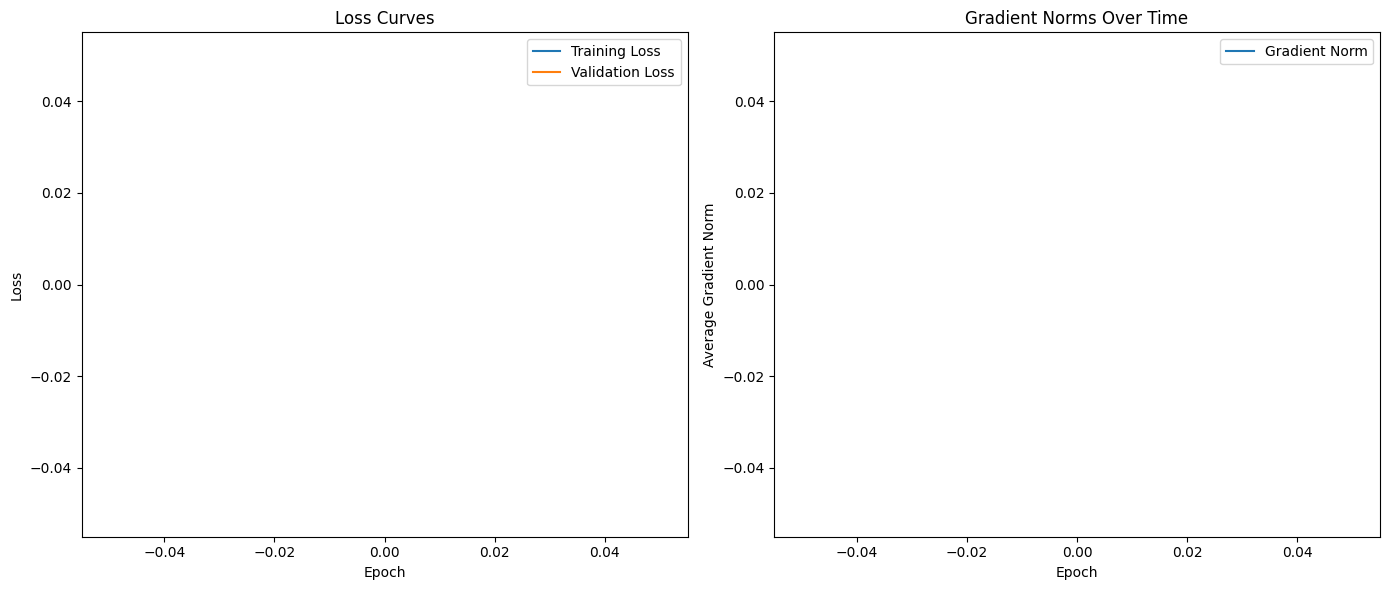

In [28]:
# # Custom callback to track gradients and learning curves
# class GradientLogger(Callback):
#     def __init__(self, validation_data, batch_size=32):
#         super(GradientLogger, self).__init__()
#         self.validation_data = validation_data
#         self.batch_size = batch_size
#         self.epoch_gradients = []  # Store gradients for each epoch
#         self.epoch_losses = []  # Store losses for each epoch
#         self.epoch_val_losses = []  # Store validation losses
#         self.loss_fn = tf.keras.losses.MeanSquaredError()

#     def on_epoch_end(self, epoch, logs=None):
#         # Compute gradients
#         X_val, y_val = self.validation_data
#         with tf.GradientTape() as tape:
#             y_pred = self.model(X_train, training=True)  # Using self.model instead of passing model in init
#             # Manually compute MSE loss instead of calling self.model.loss
#             loss_value = self.loss_fn(y_train, y_pred if y_pred!=None else 0)

#         gradients = tape.gradient(loss_value, self.model.trainable_variables)
#         grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])
        
#         # Log the gradients and losses
#         self.epoch_gradients.append(grad_norm)
#         self.epoch_losses.append(logs["loss"])
#         self.epoch_val_losses.append(logs["val_loss"])

#     def plot_learning_curves(self):
#         # Plot the loss curves
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(self.epoch_losses, label="Training Loss")
#         plt.plot(self.epoch_val_losses, label="Validation Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.title("Loss Curves")
#         plt.legend()

#         # Plot the gradient norms
#         plt.subplot(1, 2, 2)
#         plt.plot(self.epoch_gradients, label="Gradient Norm")
#         plt.xlabel("Epoch")
#         plt.ylabel("Average Gradient Norm")
#         plt.title("Gradient Norms Over Time")
#         plt.legend()

#         plt.tight_layout()
#         plt.show()

# # Assuming the dataset is already loaded and preprocessed (train_x, train_y, etc.)
# X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
# X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

# # Initialize the custom callback
# gradient_logger = GradientLogger(validation_data=(X_val, test_y))

# # Define the model
# model = Sequential([
#     ImputationLayer(strategy="mean", input_shape=(286, 1)),
#     Conv1D(filters=64, kernel_size=3, activation='relu'),
#     Conv1D(filters=128, kernel_size=3, activation='relu'),
#     Conv1D(filters=256, kernel_size=3, activation='relu'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(1)  # Output layer for regression
# ])


# # Compile the model with a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# # Train the model with the custom callback
# history = model.fit(X_train, train_y, 
#                     epochs=20, 
#                     batch_size=32, 
#                     validation_split=0.2, 
#                     callbacks=[gradient_logger])

# # After training, plot the learning curves and gradient norms
# gradient_logger.plot_learning_curves()

In [24]:
# # Custom callback to track gradients and learning curves
# class GradientLogger(Callback):
#     def __init__(self, validation_data, batch_size=32):
#         super(GradientLogger, self).__init__()
#         self.validation_data = validation_data
#         self.batch_size = batch_size
#         self.epoch_gradients = []  # Store gradients for each epoch
#         self.epoch_losses = []  # Store losses for each epoch
#         self.epoch_val_losses = []  # Store validation losses

#     def on_epoch_end(self, epoch, logs=None):
#         # Compute gradients
#         X_val, y_val = self.validation_data
#         with tf.GradientTape() as tape:
#             y_pred = self.model(X_train, training=True)  # Using self.model instead of passing model in init
#             # Manually compute MSE loss using tf.keras.losses.mean_squared_error
#             loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_train, y_pred))

#         gradients = tape.gradient(loss_value, self.model.trainable_variables)
#         grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])
        
#         # Log the gradients and losses
#         self.epoch_gradients.append(grad_norm)
#         self.epoch_losses.append(logs["loss"])
#         self.epoch_val_losses.append(logs["val_loss"])

#     def plot_learning_curves(self):
#         # Plot the loss curves
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(self.epoch_losses, label="Training Loss")
#         plt.plot(self.epoch_val_losses, label="Validation Loss")
#         plt.xlabel("Epoch")
#         plt.ylabel("Loss")
#         plt.title("Loss Curves")
#         plt.legend()

#         # Plot the gradient norms
#         plt.subplot(1, 2, 2)
#         plt.plot(self.epoch_gradients, label="Gradient Norm")
#         plt.xlabel("Epoch")
#         plt.ylabel("Average Gradient Norm")
#         plt.title("Gradient Norms Over Time")
#         plt.legend()

#         plt.tight_layout()
#         plt.show()

# # Assuming the dataset is already loaded and preprocessed (train_x, train_y, etc.)
# X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
# X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

# # Initialize the custom callback
# gradient_logger = GradientLogger(validation_data=(X_val, test_y))

# # Compile the model with a lower learning rate
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# # Train the model with the custom callback
# history = model.fit(X_train, train_y, 
#                     epochs=20, 
#                     batch_size=32, 
#                     validation_split=0.2, 
#                     callbacks=[gradient_logger])

# # After training, plot the learning curves and gradient norms
# gradient_logger.plot_learning_curves()

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: nan

AttributeError: module 'keras._tf_keras.keras.losses' has no attribute 'mean_squared_error'

Epoch 1/20


/tmp/ipykernel_454/1504077826.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(ImputationLayer, self).__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - loss: 28.3684 - val_loss: 31.2478
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - loss: 24.6444 - val_loss: 31.7718
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - loss: 18.3784 - val_loss: 33.7122
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - loss: 7.8253 - val_loss: 33.1797
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - loss: 3.0162 - val_loss: 32.7394
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - loss: 1.4964 - val_loss: 34.1162
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - loss: 0.8503 - val_loss: 31.7597
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - loss: 0.5417 - val_loss: 31.8990
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - loss: 0.3138 - val_loss: 30.8170
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - loss: 0.3377 - val_loss: 31.7249
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - loss: 0.3808 - val_loss: 31.4884
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/s

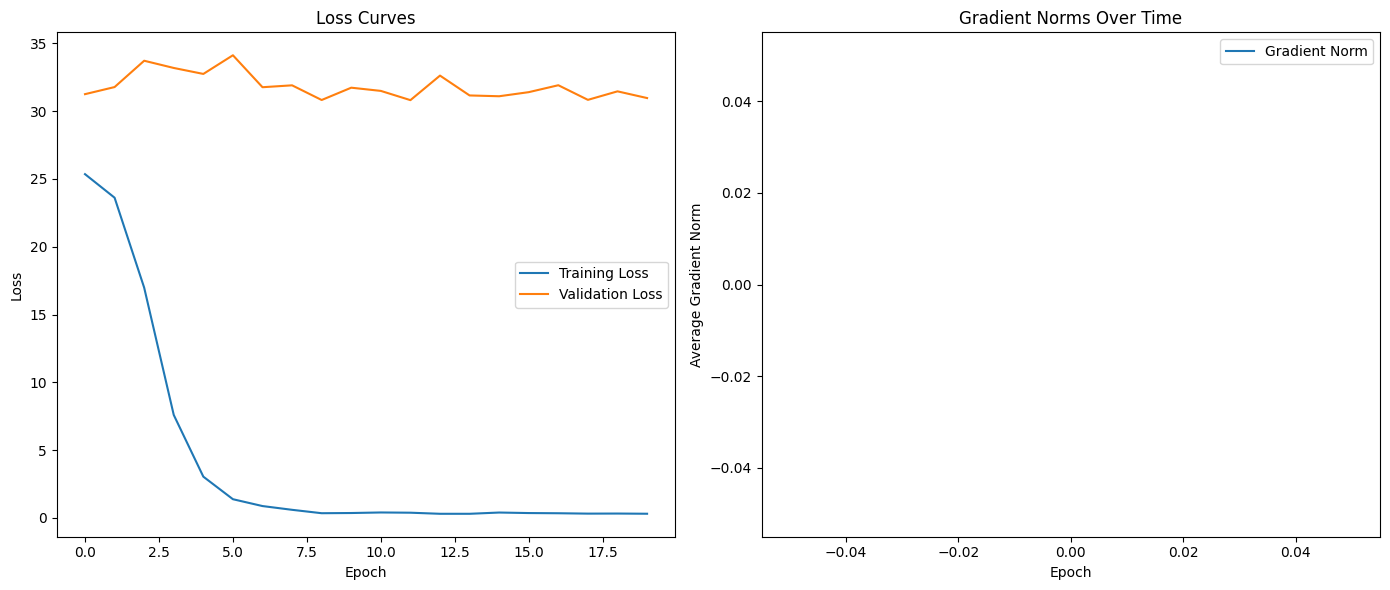

In [29]:
# Custom callback to track gradients and learning curves
class GradientLogger(Callback):
    def __init__(self, validation_data, batch_size=32):
        super(GradientLogger, self).__init__()
        self.validation_data = validation_data
        self.batch_size = batch_size
        self.epoch_gradients = []  # Store gradients for each epoch
        self.epoch_losses = []  # Store losses for each epoch
        self.epoch_val_losses = []  # Store validation losses
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def on_epoch_end(self, epoch, logs=None):
        # Compute gradients
        X_val, y_val = self.validation_data
        with tf.GradientTape() as tape:
            y_pred = self.model(X_train, training=True)  # Using self.model
            # Manually compute MSE loss using the instantiated loss function
            loss_value = self.loss_fn(y_train, y_pred)

        # Clip gradients to avoid large values (optional)
        gradients = tape.gradient(loss_value, self.model.trainable_variables)
        grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])

        # Log the gradients and losses
        self.epoch_gradients.append(grad_norm)
        self.epoch_losses.append(logs["loss"])
        self.epoch_val_losses.append(logs["val_loss"])

    def plot_learning_curves(self):
        # Plot the loss curves
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_losses, label="Training Loss")
        plt.plot(self.epoch_val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curves")
        plt.legend()

        # Plot the gradient norms
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_gradients, label="Gradient Norm")
        plt.xlabel("Epoch")
        plt.ylabel("Average Gradient Norm")
        plt.title("Gradient Norms Over Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Assuming the dataset is already loaded and preprocessed (train_x, train_y, etc.)
X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

# Ensure no NaNs in the target values
train_y = np.nan_to_num(train_y, nan=0.0)
test_y = np.nan_to_num(test_y, nan=0.0)

# Initialize the custom callback
gradient_logger = GradientLogger(validation_data=(X_val, test_y))

# Define the model
model = Sequential([
    ImputationLayer(strategy="mean", input_shape=(286, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model with the custom callback
history = model.fit(X_train, train_y, 
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[gradient_logger])

# After training, plot the learning curves and gradient norms
gradient_logger.plot_learning_curves()
   

In [34]:
%pip install tensorflow-probability
%pip install tf_keras

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_27766/3456529102.py:50: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(ImputationLayer, self).__init__(**kwargs)
2024-09-20 01:16:15.231261: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - loss: 22508.1250

/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:617: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 837ms/step - loss: 22367.7363 - val_loss: -3340.7056
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 792ms/step - loss: 3990.8401 - val_loss: 2798.7976
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 799ms/step - loss: 1236.7653 - val_loss: -3437.8066
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 795ms/step - loss: -2350.9573 - val_loss: 5294.8447
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 811ms/step - loss: -994.8201 - val_loss: -2310.7219
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 847ms/step - loss: -4306.0225 - val_loss: -6861.2920
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 797ms/step - loss: -6233.3896 - val_loss: -9069.5889
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 812ms/step - loss: -7985.1001 - val_loss: -9717.9668
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 798ms/step - loss: -7379.9287 - val_loss: -7103.3462
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 774ms/step - loss: -9515.2979 - val_loss: -9287.2344
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - loss: -10

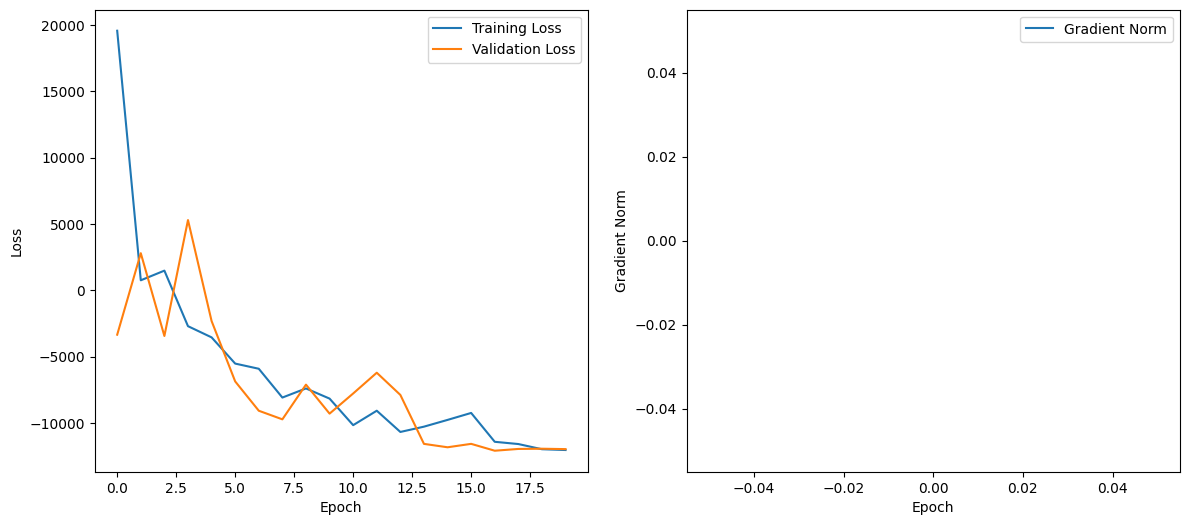

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Layer, Conv1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
# Define Bayesian Dense Layer
tfd = tfp.distributions

class DenseVariational(tf.keras.layers.Layer):
    def __init__(self, units, kl_weight, activation=None):
        super(DenseVariational, self).__init__()
        self.units = units
        self.kl_weight = kl_weight
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w_mu = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.w_rho = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b_mu = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
        self.b_rho = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)

    def call(self, inputs):
        w_sigma = tf.math.softplus(self.w_rho)
        b_sigma = tf.math.softplus(self.b_rho)
        w = self.w_mu + w_sigma * tf.random.normal(shape=self.w_mu.shape)
        b = self.b_mu + b_sigma * tf.random.normal(shape=self.b_mu.shape)

        # KL Divergence between the posterior and prior
        # kl_loss = self.kl_weight * (tf.reduce_sum(tfd.Normal(0, 1).log_prob(w)) + tf.reduce_sum(tfd.Normal(0, 1).log_prob(b)))
        # self.add_loss(kl_loss)
        kl_loss = self.kl_weight * (tf.reduce_sum(tfd.Normal(0, 1).log_prob(w)) + tf.reduce_sum(tfd.Normal(0, 1).log_prob(b)))
        self.add_loss(kl_loss)

        return self.activation(tf.matmul(inputs, w) + b)

# Custom Imputation Layer with NaN Check
class ImputationLayer(Layer):
    def __init__(self, strategy="mean", **kwargs):
        super(ImputationLayer, self).__init__(**kwargs)
        self.strategy = strategy

    def build(self, input_shape):
        if self.strategy == "mean":
            self.feature_means = self.add_weight(shape=(input_shape[1],), initializer="zeros", trainable=False)
        super(ImputationLayer, self).build(input_shape)

    def call(self, inputs):
        if self.strategy == "mean":
            is_not_nan = tf.math.logical_not(tf.math.is_nan(inputs))
            feature_sums = tf.reduce_sum(tf.where(is_not_nan, inputs, 0.0), axis=0)
            feature_counts = tf.reduce_sum(tf.cast(is_not_nan, tf.float32), axis=0)
            feature_means = feature_sums / tf.maximum(feature_counts, 1.0)
            self.feature_means.assign(tf.squeeze(feature_means))
            imputed_inputs = tf.where(tf.math.is_nan(inputs), tf.reshape(self.feature_means, (1, -1, 1)), inputs)
        else:
            raise ValueError(f"Strategy '{self.strategy}' not supported.")
        return tf.where(tf.math.is_nan(imputed_inputs), 0.0, imputed_inputs)

# Custom callback to track gradients and learning curves
class GradientLogger(Callback):
    def __init__(self, validation_data, batch_size=32):
        super(GradientLogger, self).__init__()
        self.validation_data = validation_data
        self.batch_size = batch_size
        self.epoch_gradients = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        with tf.GradientTape() as tape:
            y_pred = self.model(X_train, training=True)
            loss_value = self.model.compiled_loss(y_train, y_pred)

        gradients = tape.gradient(loss_value, self.model.trainable_variables)
        grad_norm = np.mean([tf.norm(grad).numpy() for grad in gradients if grad is not None])

        self.epoch_gradients.append(grad_norm)
        self.epoch_losses.append(logs["loss"])
        self.epoch_val_losses.append(logs["val_loss"])

    def plot_learning_curves(self):
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_losses, label="Training Loss")
        plt.plot(self.epoch_val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_gradients, label="Gradient Norm")
        plt.xlabel("Epoch")
        plt.ylabel("Gradient Norm")
        plt.legend()
        plt.show()

# Assuming train_x and train_y are preprocessed
X_train = train_x.values.reshape(train_x.shape[0], train_x.shape[1], 1)
X_val = test_x.values.reshape(test_x.shape[0], test_x.shape[1], 1)

train_y = np.nan_to_num(train_y, nan=0.0)
test_y = np.nan_to_num(test_y, nan=0.0)

# Initialize the custom callback
gradient_logger = GradientLogger(validation_data=(X_val, test_y))

# Define the Bayesian model
kl_weight = 1 / X_train.shape[0]

model = Sequential([
    ImputationLayer(strategy="mean", input_shape=(286, 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    Flatten(),
    DenseVariational(128, kl_weight=kl_weight, activation='relu'),
    DenseVariational(64, kl_weight=kl_weight, activation='relu'),
    DenseVariational(1, kl_weight=kl_weight)
])

# Compile the model with a Bayesian objective function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train the model with the custom callback
history = model.fit(X_train, train_y, 
                    epochs=20, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[gradient_logger])

# After training, plot the learning curves and gradient norms
gradient_logger.plot_learning_curves()